## Naive Bayes Classification
Naive Bayes is a classification algorithm based on Bayes' Theorem, which is used in machine learning for tasks like spam detection, sentiment analysis, and classification of text. It’s called "naive" because it assumes that all features (predictors) used in the classification are independent of each other, which is a simplifying assumption that often doesn’t hold in real-world data. Despite this simplification, Naive Bayes can perform surprisingly well in many practical applications.

In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
df = pd.read_csv('train.csv')
# preview the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Exploratory Data Analysis (EDA)

Let's explore the relationships between various features and survival to understand their importance.


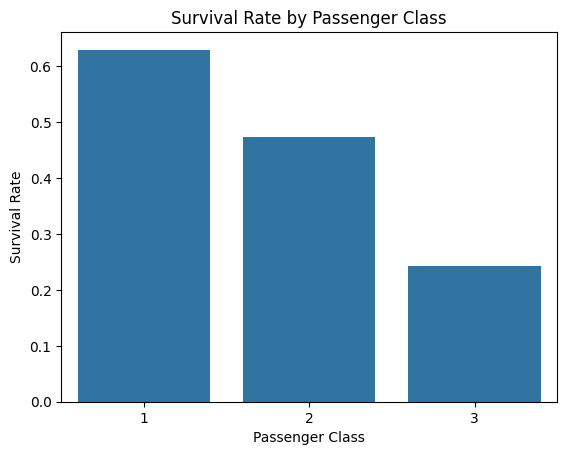

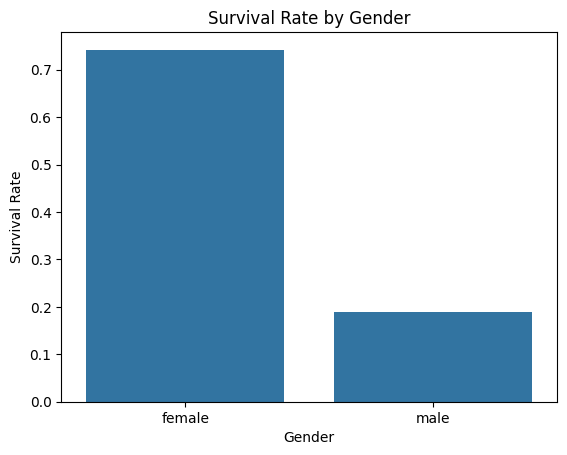

In [3]:
# Survival rate by class
class_survival = df[['Pclass', 'Survived']].groupby(['Pclass']).mean()
sns.barplot(x=class_survival.index, y=class_survival['Survived'])
plt.title("Survival Rate by Passenger Class")
plt.ylabel("Survival Rate")
plt.xlabel("Passenger Class")
plt.show()

# Gender-based survival analysis
gender_survival = df[['Sex', 'Survived']].groupby(['Sex']).mean()
sns.barplot(x=gender_survival.index, y=gender_survival['Survived'])
plt.title("Survival Rate by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Gender")
plt.show()


### Data Preprocessing

Data preprocessing steps:
1. Map `Sex` to numeric values.
2. Impute missing `Age` values using grouped medians.
3. Drop irrelevant columns (`Ticket`, `Cabin`, `Name`, `PassengerId`).
4. Bin continuous variables (`Age` and `Fare`) into discrete categories.


In [4]:
# Encode categorical values
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Impute missing Age values
df['Age'] = df['Age'].fillna(df.groupby(['Sex', 'Pclass'])['Age'].transform('median'))

# Drop irrelevant features
df = df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

# Create Age bins
df['AgeBand'] = pd.cut(df['Age'], 5, labels=[0, 1, 2, 3, 4])

# Create Fare bins
df['FareBand'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])

# Convert categorical columns to integers
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df = df.dropna()


This step helps analyze the relationship between the passenger class (Pclass) and survival rate (Survived). By calculating and sorting the mean survival rate for each class, you can gain insights into whether certain classes had higher survival rates, which could be important for model feature engineering or understanding patterns in the data.

In [5]:
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.626168
1,2,0.472826
2,3,0.242363


This analysis helps identify the relationship between gender (Sex) and survival rate (Survived). For instance, if the mean survival rate for females is higher than for males, this insight could be crucial for understanding gender-based survival patterns or could inform further feature engineering for predictive modeling.

In [6]:
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.740385
0,0,0.188908


This visualization helps to explore the age distribution within the two survival categories (survived vs. not survived). It can highlight age-related patterns, such as whether younger individuals had a higher survival rate, or whether there was any significant age difference between those who survived and those who did not. This is valuable for understanding how age might be a contributing factor to survival prediction.

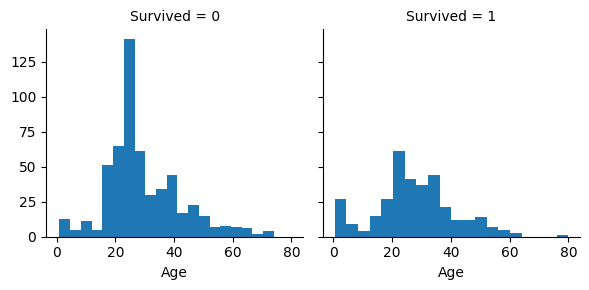

In [7]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Model Training and Evaluation

Split the data into training and testing sets, train the Gaussian Naive Bayes model, and evaluate its performance.


In [8]:
# Define features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Predictions
y_pred = naive_bayes.predict(X_test)


### Model Evaluation Metrics


Accuracy: 0.78
Confusion Matrix:
[[85 24]
 [16 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       109
           1       0.69      0.77      0.73        69

    accuracy                           0.78       178
   macro avg       0.76      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178



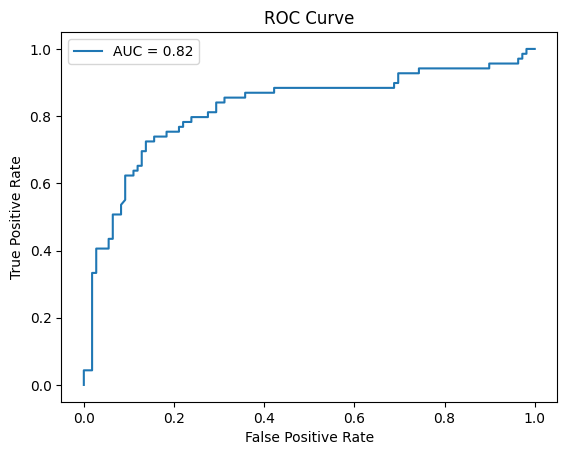

In [9]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# ROC Curve
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Cross-Validation

Use cross-validation to evaluate the model more robustly.


In [10]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(naive_bayes, X, y, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.74157303 0.7752809  0.74719101 0.80898876 0.77966102]
Mean Accuracy: 0.7705389449628643


---

### Manual Implementation of Naive Bayes Algorithm

The Naive Bayes algorithm uses Bayes' Theorem to calculate the probability of each class given a feature set. The "naive" assumption is that all features are independent. This implementation will compute the probabilities manually to classify the Titanic passengers.

#### Algorithm Description

The Naive Bayes algorithm works as follows:
1. **Bayes' Theorem**:  
   $P(Class | Data) = \frac{P(Data | Class) \cdot P(Class)}{P(Data)}$
   - \(P(Class | Data)\): Posterior probability (what we aim to compute).
   - \(P(Data | Class)\): Likelihood of the data given the class.
   - \(P(Class)\): Prior probability of the class.
   - \(P(Data)\): Evidence (does not affect classification, so we can ignore it).

2. For each class:
   - Calculate the prior probability \(P(Class)\).
   - Compute the likelihood \(P(Data | Class)\) for all features by assuming feature independence.
   - Multiply the prior by the likelihood for each class.
3. Choose the class with the highest posterior probability.

---


### Step 1: Compute prior probabilities

In [11]:
# Step 1: Compute prior probabilities
def calculate_priors(y):
    classes, counts = np.unique(y, return_counts=True)
    priors = counts / len(y)
    return dict(zip(classes, priors))


### Step 2: Compute likelihoods

In [12]:

# Step 2: Compute likelihoods
def calculate_likelihoods(X, y):
    likelihoods = {}
    for feature in X.columns:
        likelihoods[feature] = {}
        for cls in np.unique(y):
            feature_given_class = X[feature][y == cls]
            likelihoods[feature][cls] = feature_given_class.value_counts(normalize=True).to_dict()
    return likelihoods



### Step 3: Predict class for each sample

In [13]:
def naive_bayes_predict(X, priors, likelihoods):
    predictions = []
    for i in range(len(X)):
        sample = X.iloc[i]
        posteriors = {}
        for cls, prior in priors.items():
            posterior = np.log(prior)  # Use log probabilities for numerical stability
            for feature in X.columns:
                value = sample[feature]
                if value in likelihoods[feature][cls]:
                    posterior += np.log(likelihoods[feature][cls][value])
                else:
                    posterior += np.log(1e-6)  # Small smoothing factor for unseen features
            posteriors[cls] = posterior
        predictions.append(max(posteriors, key=posteriors.get))
    return predictions


In [14]:
# Prepare the data
X_manual = X_train.copy()  # Use the training data
y_manual = y_train

### Step 4: Fit the model manually & Predict on test data

In [15]:
# Step 4: Fit the model manually
priors = calculate_priors(y_manual)
likelihoods = calculate_likelihoods(X_manual, y_manual)
# Step 5: Predict on test data
y_manual_pred = naive_bayes_predict(X_test, priors, likelihoods)

### Step 6: Evaluate the manual implementation

In [16]:
# Step 6: Evaluate the manual implementation
manual_accuracy = accuracy_score(y_test, y_manual_pred)
manual_conf_matrix = confusion_matrix(y_test, y_manual_pred)
manual_classification_report = classification_report(y_test, y_manual_pred)

print(f"Manual Implementation Accuracy: {manual_accuracy:.2f}")
print("Confusion Matrix (Manual):")
print(manual_conf_matrix)
print("Classification Report (Manual):")
print(manual_classification_report)

Manual Implementation Accuracy: 0.74
Confusion Matrix (Manual):
[[86 23]
 [23 46]]
Classification Report (Manual):
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       109
           1       0.67      0.67      0.67        69

    accuracy                           0.74       178
   macro avg       0.73      0.73      0.73       178
weighted avg       0.74      0.74      0.74       178

